# Bagging

## 基本思想

欲得到泛化能力强的集成，个体学习器应该尽可能相互独立，在现实任务中很难做到，但一种可能的做法是**对训练样本进行采样，产生若干不同的子集，再从每个子集训练出一个基学习器；我们还希望每个学习器性能不要太差，所以子集之间应该有相互交叠，这样不至于导致训练集太少。**

**Bagging(bootstrap aggregating 的缩写) 是并行式集成学习方法最著名的代表。它的主要特点就在于对训练集的采样，具体见“机器学习理论基础”章节的“自助法”。**

对于训练得到的T个个体学习器，对于**<span class="mark"><span class="mark">分类问题可以采用简单投票法</span>，对回归任务采用简单平均法</span>（即每个基学习器使用相同的权重进行投票、平均）**。考虑到T一般不是很大，所以 **Bagging 集成与直接使用基学习器算法训练一个学习器的复杂度同阶**， 这说明 Bagging 集成是一个很高效的集成学习算法。

另外，与 Adaboost 只适用于二分类任务不同， **Bagging 不用修改就可以用于多分类、回归等任务。**

<span class="mark">从偏差-方差角度看</span>，**Bagging 主要关注降低方差（自助采样法有利于降低过拟合）**，因此它在不剪枝决策树、神经网络等容易受到样本扰动的学习器上效用更为明显。

每个基学习器单独的偏差都高于原始训练集上训练的偏差（即拟合程度不够），但是通过 aggregating ，同时降低了偏差和方差。**最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。**

## [sklearn.ensemble.BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#rb1846455d0e5-3)

下面我们对比下单个决策器和集成500个决策树的准确率。

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [34]:
bag_clf.base_estimator_
# bag_clf.oob_decision_function_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

下面我们画出单个决策树（左图）和500个决策树组成的bagging集成（有图）。

In [21]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

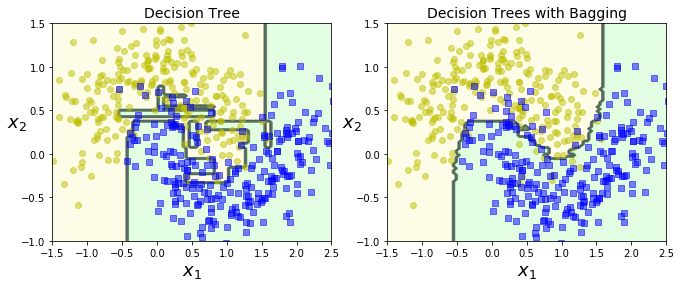

In [23]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

对比两图发现，二者偏差相近，但是集成的方差更小（两者在训练集上的错误数量近似，但集成的决策边界更规则）。

**包外估计**

如果对集成的每个基学习器使用自助采样法，也就是有放回采样，那么理论上有大约37%的样本不会被采集到，每个基学习器的37%部分都不同，我们称剩余37%未被采样的实例称为**包外实例**。

可以用这些实例来进行集成评估，不需要单独进行交叉验证。在sklearn中创建 BaggingClassifier 时，设置 oob_score=True 时，就可以请求训练结束时自动进行包外估计。通过 oob_score_ 可以得到最终的评估分数。

In [26]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [27]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

按照是否要对训练实例和特征都进行抽样可以分为两类算法：
1. Random Patches 方法： 对实例和特征都进行抽样(max_samples < 1.0 且 max_features < 1.0)；
2. 随机子空间法： 保留所有训练实例，但是对特征进行抽样(bootstrao=False, max_samples=1.0,且 max_features < 1.0)。

对特征进行抽样为预测带来更大的随机性，以略高一些的偏差换取更低的方差。

## 随机森林

### 基本思想

随机森林（Random Forest）是 Bagging 的一个扩展变体。随机森林的个体学习器是决策树，但它的特点在于：

1. 它不仅通过对样本集重新采样来进行集成学习；
2. 传统决策树在每个节点选择划分属性时是在当前节点的属性集合中选择一个最优属性不同，它是随机选择一个包含k个属性的子集，再从里面选择一个最优属性进行划分。k 控制了随机性的选择程度，假设样本一共有 d 个属性，一般情况下推荐 $k = \log_2 d$。

随机森林简单、容易实现，计算开销小，但是在很多现实任务中展现出很强大的性能，被誉为“代表集成学习技术水平的方法”。**RF的多样性不仅通过对样本扰动，还有属性扰动，这使得最终集成的泛化性能通过个体学习器之间差异度的增加而进一步提升，最大程度上降低了过拟合。**

### [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [35]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [43]:
np.sum(y_pred == y_pred_rf) / float(len(y_pred))  # almost identical predictions

0.97599999999999998

可以看到，在参数一致的情况下，bagging和random forest 的预测结果近似。

### 了解特征重要性与特征选择

按照随机森林的基尼指数或者信息熵来选择不同节点的分裂特征的特性，可以知道重要的特征更可能出现在靠近根节点的位置，不重要的特征通常出现靠近叶节点的位置。

sklearn中通过feature_importances_来计算一个特征在森林中所有树上的平均深度。

In [45]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

('sepal length (cm)', 0.11249225099876374)
('sepal width (cm)', 0.023119288282510326)
('petal length (cm)', 0.44103046436395765)
('petal width (cm)', 0.42335799635476812)


In [46]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

### [sklearn.ensemble.ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)

极端随机树与随机森林有两点主要区别：

1. ET中每棵树采用所有训练样本，即每棵树的样本集相同；
2. RF在特征子集中选择最优分叉特征，而ET直接随机选择分叉特征。

优缺点：基本与随机森林类似。由于ET采用所有训练样本使得计算量相对RF增大，而采用随机特征，减少了信息增益或基尼指数的计算过程，计算量又相对RF减少。

注：**看sklearn里ET这个模型的参数和RF并没有什么区别，没有体现出上面的两点区别。一个解释是，虽然和RF接口全部一致，但有可能在内部的算法设计不同，比如criterion的default参数是gini,但实际里面是进行随机选取特征，并不计算gini指数。**